In [1]:
!git clone https://github.com/adimunot21/transformer-from-scratch.git
%cd transformer-from-scratch
!curl -o data/input.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

import torch
print(f"CUDA: {torch.cuda.is_available()}, GPU: {torch.cuda.get_device_name(0)}")

Cloning into 'transformer-from-scratch'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
Receiving objects: 100% (48/48), 411.33 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (15/15), done.
remote: Total 48 (delta 15), reused 46 (delta 13), pack-reused 0 (from 0)
/content/transformer-from-scratch
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  3007k      0 --:--:-- --:--:-- --:--:-- 3000k
CUDA: True, GPU: Tesla T4


In [2]:
from src.bpe_tokenizer import BPETokenizer
from torch.utils.data import Dataset, DataLoader

with open("data/input.txt", "r") as f:
    text = f.read()

tok = BPETokenizer()
tok.train(text, num_merges=512)

class BPEDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size
    def __len__(self):
        return len(self.data) - self.block_size
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+1:idx+self.block_size+1]
        return x, y

all_tokens = tok.encode(text)
data = torch.tensor(all_tokens, dtype=torch.long)
split = int(len(data) * 0.9)
train_loader = DataLoader(BPEDataset(data[:split], 256), batch_size=64, shuffle=True)
val_loader = DataLoader(BPEDataset(data[split:], 256), batch_size=64, shuffle=True)
print(f"Tokens: {len(all_tokens):,} | Vocab: {tok.vocab_size}")

Training BPE with 512 merges...
Initial chunks: 209,892
Initial tokens: 1,115,394
  Merge   50:      'e, ' (count=2,450) → token 305 | total tokens: 774,535
  Merge  100:       'di' (count=1,434) → token 355 | total tokens: 685,574
  Merge  150:       'de' (count=887) → token 405 | total tokens: 626,587
  Merge  200:     'him ' (count=662) → token 455 | total tokens: 589,234
  Merge  250:       'so' (count=518) → token 505 | total tokens: 560,027
  Merge  300:       'ON' (count=407) → token 555 | total tokens: 537,265
  Merge  350:       'mp' (count=322) → token 605 | total tokens: 519,488
  Merge  400:    'ER:\n' (count=275) → token 655 | total tokens: 504,666
  Merge  450:      'erv' (count=239) → token 705 | total tokens: 491,699
  Merge  500:     't,\n' (count=218) → token 755 | total tokens: 480,198

Done! Vocab size: 768
Final token count: 477,624
Compression ratio: 2.34x
Tokens: 477,624 | Vocab: 768


In [3]:
import math, time
from src.model import GPT

device = torch.device("cuda")

model = GPT(
    vocab_size=tok.vocab_size,
    d_model=192,
    n_heads=6,
    n_layers=4,       # ← was 6, reduced to prevent memorization
    block_size=256,
    dropout=0.25,      # ← was 0.1, more aggressive regularization
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,} (was ~3M, now should be ~2M)")

# weight_decay=0.1 penalizes large weights — another regularization tool
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)

MAX_STEPS = 5000
WARMUP = 500

def get_lr(step):
    if step < WARMUP:
        return 3e-4 * (step + 1) / WARMUP
    progress = (step - WARMUP) / (MAX_STEPS - WARMUP)
    return 3e-4 * 0.5 * (1.0 + math.cos(math.pi * progress))

@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        total, it = 0.0, iter(loader)
        for _ in range(20):
            try: xb, yb = next(it)
            except StopIteration: it = iter(loader); xb, yb = next(it)
            _, loss = model(xb.to(device), yb.to(device))
            total += loss.item()
        out[name] = total / 20
    model.train()
    return out

train_iter = iter(train_loader)
model.train()
t0 = time.time()
train_losses, val_losses = [], []

for step in range(MAX_STEPS):
    try: xb, yb = next(train_iter)
    except StopIteration: train_iter = iter(train_loader); xb, yb = next(train_iter)
    xb, yb = xb.to(device), yb.to(device)

    lr = get_lr(step)
    for pg in optimizer.param_groups: pg["lr"] = lr

    _, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if step % 250 == 0 or step == MAX_STEPS - 1:
        losses = estimate_loss()
        gap = losses["val"] - losses["train"]
        print(f"Step {step:5d} | train: {losses['train']:.4f} | val: {losses['val']:.4f} | gap: {gap:.4f} | lr: {lr:.2e} | time: {time.time()-t0:.0f}s")
        train_losses.append(losses["train"])
        val_losses.append(losses["val"])

print(f"\nDone in {time.time()-t0:.0f}s")

Parameters: 2,122,368 (was ~3M, now should be ~2M)
Step     0 | train: 6.6861 | val: 6.6898 | gap: 0.0038 | lr: 6.00e-07 | time: 3s
Step   250 | train: 5.0542 | val: 5.0749 | gap: 0.0207 | lr: 1.51e-04 | time: 41s
Step   500 | train: 4.1801 | val: 4.3454 | gap: 0.1653 | lr: 3.00e-04 | time: 80s
Step   750 | train: 3.9338 | val: 4.1582 | gap: 0.2245 | lr: 2.98e-04 | time: 122s
Step  1000 | train: 3.7808 | val: 4.0765 | gap: 0.2957 | lr: 2.91e-04 | time: 165s
Step  1250 | train: 3.6204 | val: 3.9757 | gap: 0.3553 | lr: 2.80e-04 | time: 207s
Step  1500 | train: 3.4841 | val: 3.9046 | gap: 0.4205 | lr: 2.65e-04 | time: 249s
Step  1750 | train: 3.3844 | val: 3.8149 | gap: 0.4305 | lr: 2.46e-04 | time: 291s
Step  2000 | train: 3.2902 | val: 3.7696 | gap: 0.4794 | lr: 2.25e-04 | time: 333s
Step  2250 | train: 3.2092 | val: 3.6975 | gap: 0.4884 | lr: 2.01e-04 | time: 375s
Step  2500 | train: 3.1347 | val: 3.6542 | gap: 0.5195 | lr: 1.76e-04 | time: 418s
Step  2750 | train: 3.0710 | val: 3.6357

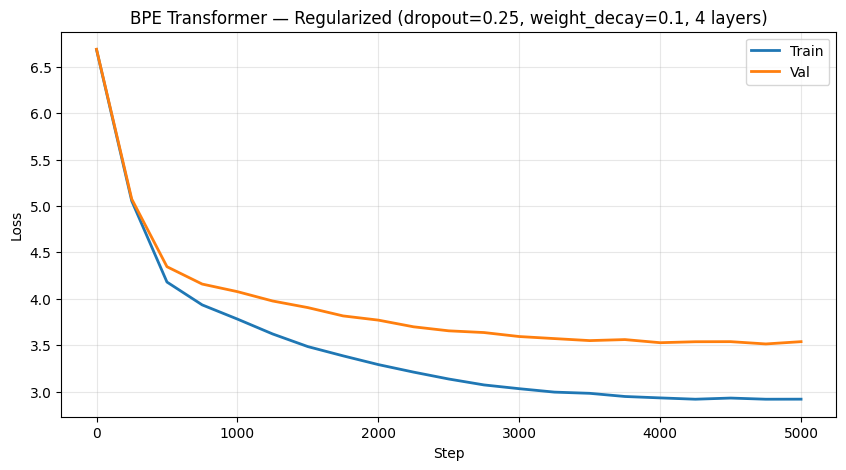


Final train: 2.9175 | val: 3.5374 | gap: 0.6199
Previous:    train: 2.1057 | val: 3.5123 | gap: 1.4066


In [4]:
import matplotlib.pyplot as plt

steps = [i * 250 for i in range(len(train_losses))]
plt.figure(figsize=(10, 5))
plt.plot(steps, train_losses, label="Train", linewidth=2)
plt.plot(steps, val_losses, label="Val", linewidth=2)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("BPE Transformer — Regularized (dropout=0.25, weight_decay=0.1, 4 layers)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig("notebooks/bpe_regularized_loss.png", dpi=150)
plt.show()

# Print the gap comparison
print(f"\nFinal train: {train_losses[-1]:.4f} | val: {val_losses[-1]:.4f} | gap: {val_losses[-1]-train_losses[-1]:.4f}")
print(f"Previous:    train: 2.1057 | val: 3.5123 | gap: 1.4066")

In [5]:
from google.colab import files
files.download("notebooks/bpe_regularized_loss.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>